In [9]:
import geopandas
import urllib
import shapely
import matplotlib.pyplot as plt
from math import sin, cos, sqrt, atan2, radians
import json
from PIL import Image
from dotenv import load_dotenv
import os
import pandas as pd

load_dotenv()

def getDistance(lat1, lon1, lat2, lon2):
    R = 6373.0
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

## Using Google Maps and GADM database

In [2]:
world = geopandas.read_file("gadm36.gpkg")
print(world.columns)

Index(['UID', 'GID_0', 'ID_0', 'NAME_0', 'GID_1', 'ID_1', 'NAME_1',
       'VARNAME_1', 'NL_NAME_1', 'HASC_1', 'CC_1', 'TYPE_1', 'ENGTYPE_1',
       'VALIDFR_1', 'VALIDTO_1', 'REMARKS_1', 'GID_2', 'ID_2', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'HASC_2', 'CC_2', 'TYPE_2', 'ENGTYPE_2',
       'VALIDFR_2', 'VALIDTO_2', 'REMARKS_2', 'GID_3', 'ID_3', 'NAME_3',
       'VARNAME_3', 'NL_NAME_3', 'HASC_3', 'CC_3', 'TYPE_3', 'ENGTYPE_3',
       'VALIDFR_3', 'VALIDTO_3', 'REMARKS_3', 'GID_4', 'ID_4', 'NAME_4',
       'VARNAME_4', 'CC_4', 'TYPE_4', 'ENGTYPE_4', 'VALIDFR_4', 'VALIDTO_4',
       'REMARKS_4', 'GID_5', 'ID_5', 'NAME_5', 'CC_5', 'TYPE_5', 'ENGTYPE_5',
       'REGION', 'VARREGION', 'zone', 'geometry'],
      dtype='object')


In [3]:

def staticmap(location, size="500x400", maptype="terrain", scale=2, zoom=10):
    maps_key = os.getenv("GOOGLE_MAPS_API")
    staticmap_base_url = 'https://maps.googleapis.com/maps/api/staticmap'
    
    # Get the city's name if given such as "Maastricht, NL"
    city = location.split(",")[0]
#     if len(location.split(",")) > 1:
#         country = location.split(",")[1]
#         cityData = world[(world["NAME_2"]==city) & (world["NAME_0"]==country)]
#     else:
    cityData = world[world["NAME_2"]==city]
    
    print(cityData[["NAME_0", "NAME_1","NAME_2","NAME_3","geometry"]])
    for x in cityData["geometry"]:
        tolerance = 0.0001
        pathTooLong = True
        while pathTooLong:
            if isinstance(x, shapely.geometry.Polygon):
                coords_list = list(x.exterior.coords)
            else:
                coords_list = list(x.geoms[0].exterior.coords)

            pathCode = "color:0x0000ff80|weight:1|geodesic:true|fillcolor:0x0000ff80"
            for lat,long in coords_list:
                pathCode = f"{pathCode}|{long},{lat}"
#             print("PathCode length",len(pathCode))
            
            # Instead of zoom or center give marker of top left and bottom right (x.bounds)
            # Then image fits perfectly
            lat1, long1, lat2, long2 = x.bounds
            distance = getDistance(lat1, long1, lat2, long2)
#             markerCode = f"size:tiny|{x.bounds[3]},{x.bounds[0]}|{x.bounds[1]},{x.bounds[2]}"
            markerCode = f"size:tiny|{long2},{lat1}|{long1},{lat2}"
            
            # This joins the parts of the URL together into one string.
            url = staticmap_base_url + '?' + urllib.parse.urlencode({
                "center": location,
                "size": size,
                "maptype": maptype,
                "scale": scale,
#                 "zoom": zoom,
                "key": maps_key,
                "markers": markerCode,
                "path": pathCode
            })
            # URLs for all web services are limited to 8192 characters!!
            if len(url) > 8192:
                tolerance += 0.0001
                x = x.simplify(tolerance, preserve_topology=False)
            else:
                pathTooLong = False
    
#             print("URL length: ",len(url))
    
    image = urllib.request.urlopen(url).read()
    return image, distance

In [4]:
location = "Amsterdam"
citymap, distance = staticmap(location)
print("Distance", distance)
with open("citymap.png", "wb") as f:
    f.write(citymap)
# plt.imshow(citymap)

             NAME_0         NAME_1     NAME_2 NAME_3  \
212707  Netherlands  Noord-Holland  Amsterdam   None   

                                                 geometry  
212707  MULTIPOLYGON (((5.01650 52.34405, 5.01211 52.3...  
Distance 41.48240496036253


## Use OpenStreetMap API

In [2]:
query = "Kassel, Germany"
openStreetMap_base_url = "https://nominatim.openstreetmap.org/search"
url = openStreetMap_base_url + '?' + urllib.parse.urlencode({
                "q": query,
                "format": "json",
                "polygon_geojson": 1
            })

response = urllib.request.urlopen(url).read()
responseJson = json.loads(response)


Distance:  27.18405004091734


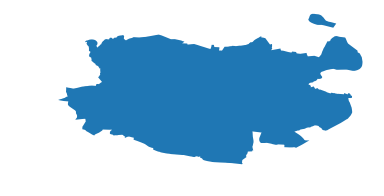

In [3]:
# find first multipolygon result (most likely the correct one)
for shape in responseJson:
    if isinstance(shapely.geometry.shape(shape["geojson"]), shapely.geometry.MultiPolygon):
        cityShape = shapely.geometry.shape(shape["geojson"])
        lat1, long1, lat2, long2 = cityShape.bounds
        distance = getDistance(lat1, long1, lat2, long2)
        break

print("Distance: ", distance)
cityGDF = geopandas.GeoDataFrame({
    "geometry": cityShape
}) 
cityGDF.plot()
plt.axis("off")
plt.savefig("city.png", transparent=True)
# world[world["NAME_2"]=="Maastricht"].plot()
# Next: Get second image and scale according to size (distance of furthest points)

In [85]:
def getCityOutline(query: str):
    openStreetMap_base_url = "https://nominatim.openstreetmap.org/search"
    url = openStreetMap_base_url + '?' + urllib.parse.urlencode({
                    "q": query,
                    "format": "json",
                    "polygon_geojson": 1
                })

    response = urllib.request.urlopen(url).read()
    responseJson = json.loads(response)
    # find first multipolygon/polygon result (most likely the correct one)
    for shape in responseJson:
        if isinstance(shapely.geometry.shape(shape["geojson"]), shapely.geometry.MultiPolygon):
            cityShape = shapely.geometry.shape(shape["geojson"])
            lat1, long1, lat2, long2 = cityShape.bounds
            distance = getDistance(lat1, long1, lat2, long2)
            cityGDF = geopandas.GeoDataFrame({
                "geometry": cityShape
            })
            return cityGDF, distance
        elif isinstance(shapely.geometry.shape(shape["geojson"]), shapely.geometry.Polygon):
            cityShape = shapely.geometry.shape(shape["geojson"])
            lat1, long1, lat2, long2 = cityShape.bounds
            distance = getDistance(lat1, long1, lat2, long2)
            cityGDF = geopandas.GeoDataFrame({
                "geometry": cityShape
            }, index=[0])
            return cityGDF, distance

    

    return cityGDF, distance

def overlayCities(city1, size1, city2, size2):
    if size1 > size2:
        bigCity = city1
        bigSize = size1
        smallCity = city2
        smallSize = size2
    else:
        bigCity = city2
        bigSize = size2
        smallCity = city1
        smallSize = size1
    # Save the cities as images
    bigCity.plot(color="red")
    plt.axis("off")
    plt.savefig("BigCity.png", transparent=True)
    plt.close()
    smallCity.plot(alpha=0.7)
    plt.axis("off")
    plt.savefig("SmallCity.png", transparent=True)
    plt.close()
    # Load images with Pillow
    bigCityIm = Image.open("BigCity.png")
    smallCityIm = Image.open("SmallCity.png")
    oldWidth, oldHeight = smallCityIm.size
    newWidth = int(oldWidth*smallSize/bigSize)
    newHeight = int(oldHeight*smallSize/bigSize)
    # Scale down the smaller city
    smallCityImScaled = smallCityIm.resize((newWidth, newHeight))
    # Find center of bigger city
    bigCityWidth, bigCityHeight = bigCityIm.size
    bigCenterW = int(bigCityWidth/2)
    bigCenterH = int(bigCityHeight/2)
    topLeftX = bigCenterW-int(newWidth/2)
    topLeftY = bigCenterH-int(newHeight/2)
    botRightX = bigCenterW+(newWidth-int(newWidth/2))
    botRightY = bigCenterH+(newHeight-int(newHeight/2))
    # Paste the small city onto the bigger one (the mask key-word reserves the transparency of the png)
    bigCityIm.paste(smallCityImScaled, (topLeftX,topLeftY,botRightX,botRightY), mask=smallCityImScaled)
    bigCityIm.save("Overlay.png", "png")
#     bigCityIm.show()
    return bigCityIm

In [86]:
city1Query = "Paris"
city2Query = "Kassel, Germany"
city1, size1 = getCityOutline(city1Query)
city2, size2 = getCityOutline(city2Query)


In [87]:
overlay = overlayCities(city1, size1, city2, size2)
overlay.show()
print(f"Diagonal size of {city1Query}: {size1}")
print(f"Diagonal size of {city2Query}: {size2}")

Diagonal size of Paris: 28.9671458170161
Diagonal size of Kassel, Germany: 27.18405004091734


In [ ]:
# TODO create a flask web service for this :D